In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle

from src.vican.vican.cam import estimate_pose_mp
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D, detect_and_draw
from src.vican.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/big_dataset"
# Edit path to the folder containing the cube calibration images.
OBJ_DATASET_PATH = "./dataset/big_dataset_object"
# Edit marker size in meters
MARKER_SIZE = 0.087                  # EDIT THIS LINE
# Check which IDs are used 
MARKER_IDS = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

for k, v in dataset.cams.items():
    dataset.cams[k].distortion = np.zeros((1,12,))

for k, v in obj_dataset.cams.items():
    obj_dataset.cams[k].distortion = np.zeros((1,12,))

# Use below to rename object calib files (if needed) !!

In [2]:
import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        #print(folder, file)
        
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path)



# Verify OpenCV detection

[2, 3, 4]


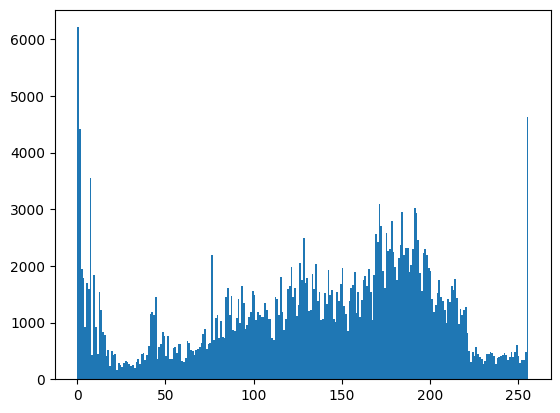

In [3]:
import cv2 as cv
im = detect_and_draw(dataset.im_data['filename'][1], 'DICT_ARUCO_ORIGINAL',
                     corner_refine='CORNER_REFINE_SUBPIX', brightness=0,
                    contrast=0)

im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

#plt.imshow(cv.equalizeHist(im))
hist_fig = plt.hist(im.flatten(), 256, [0, 256])

# Calibrate object

In [10]:
# This will compute camera-marker edges via PnP, in parallel
aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                       im_filenames=obj_dataset.im_data['filename'],
                       aruco='DICT_ARUCO_ORIGINAL',
                       marker_size=MARKER_SIZE,
                       corner_refine='CORNER_REFINE_SUBPIX',
                       marker_ids=MARKER_IDS,
                       flags='SOLVEPNP_IPPE_SQUARE',
                       brightness=0,
                       contrast=0)

pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))



Marker detection
Received 1998 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 1998 images
Finished: 9719 markers detected.


{('729',
  '729_8'): {'pose': [[-0.4311 -0.6272 -0.6487  0.0634]
   [-0.2285  0.7714 -0.5939  0.0238]
   [ 0.8729 -0.1078 -0.4759  0.721 ]
   [ 0.      0.      0.      1.    ]], 'corners': array([[356.48087, 277.33392],
         [325.39047, 256.55698],
         [363.56033, 210.20105],
         [398.3183 , 223.03839]], dtype=float32), 'reprojected_err': 0.67036664, 'im_filename': './dataset/big_dataset_object/729/729.jpg'},
 ('729',
  '729_9'): {'pose': [[-0.4173 -0.6241 -0.6606  0.1151]
   [-0.2109  0.7736 -0.5976 -0.0432]
   [ 0.884  -0.1101 -0.4544  0.7082]
   [ 0.      0.      0.      1.    ]], 'corners': array([[398.51678, 222.92976],
         [363.57477, 210.18596],
         [401.508  , 161.66455],
         [440.6336 , 169.76724]], dtype=float32), 'reprojected_err': 0.2901822, 'im_filename': './dataset/big_dataset_object/729/729.jpg'},
 ('729',
  '729_5'): {'pose': [[-0.6575 -0.6279  0.4165  0.1426]
   [-0.6037  0.7697  0.2076  0.088 ]
   [-0.4509 -0.1149 -0.8851  0.7604]
   [ 0. 

In [5]:

# Optimization - see extended paper
obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 0.13,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 2010 nodes 9719 edges
Applying constraints (0.111s).
Bipartite graph: 12 cameras, 901 timesteps, 1181 edges.
Building 12x901 adjacency and 36x2703 SO(3) sparse matrices (0.013s).
Building power graph (0.004s).


Optimizing:   0%|                                                                                           | …

Building sparse 3543x2739 incidence matrix (0.208s).
Solving sparse linear system (0.013s).
Done!


# object edges errors

0.55103725
0.47823885


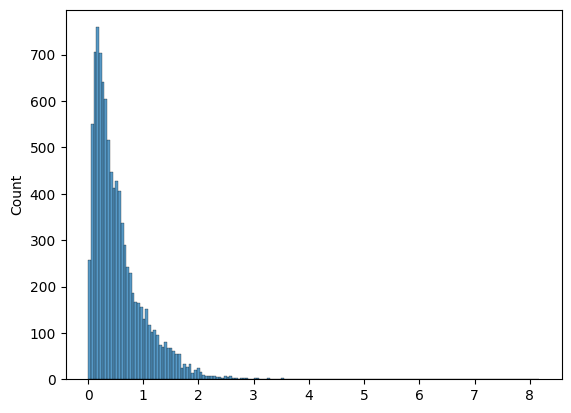

In [6]:
# plot histogram of reprojected errors
sns.histplot([edge['reprojected_err'] for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

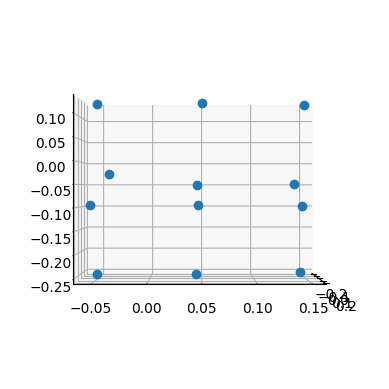

In [7]:
%matplotlib inline

xyz = np.stack([pose.inv().t() for pose in obj_pose_est.values()], axis=0)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=0, roll=0)

ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], 'o')
plt.show()

# Detect markers & estimate camera-marker poses

In [8]:
# This will compute camera-marker edges via PnP, in parallel
cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_ARUCO_ORIGINAL',
                                    marker_size=MARKER_SIZE,
                                    corner_refine='CORNER_REFINE_SUBPIX',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=0,
                                    contrast=0)

# Save it to use later, if necessary
pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))


Marker detection
Received 4020 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 3602 images
Finished: 11904 markers detected.


# cam_marker errors

0.58300084 0.46852082


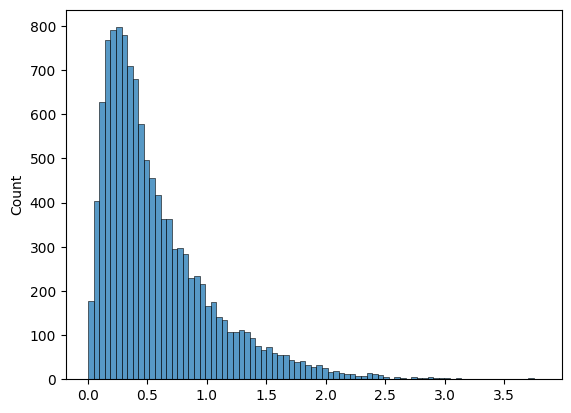

In [9]:
sns.histplot([edge['reprojected_err'] for edge in cam_marker_edges.values()])
# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in cam_marker_edges.values()]),
      np.std([edge['reprojected_err'] for edge in cam_marker_edges.values()]))

# Optimization

In [161]:
# Optimization - see extended paper
pose_est = bipartite_se3sync(cam_marker_edges,
                             constraints=obj_pose_est,
                             noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                             edge_filter=lambda edge : edge['reprojected_err'] < 0.1,
                             maxiter=4,
                             lsqr_solver="conjugate_gradient",
                             dtype=np.float32)

Received graph with 5315 nodes 11904 edges
Applying constraints (0.070s).
Bipartite graph: 3 cameras, 473 timesteps, 572 edges.
Building 3x473 adjacency and 9x1419 SO(3) sparse matrices (0.006s).
Building power graph (0.002s).


Optimizing:   0%|                                                                                             …

Building sparse 1905x1428 incidence matrix (0.110s).
Solving sparse linear system (0.006s).
Done!


# Cameras D Plot

In [152]:
def plot_frame(ax, H, label):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=0.1, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=0.1, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=0.1, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

[1.85722114 0.04122391 0.42507793]


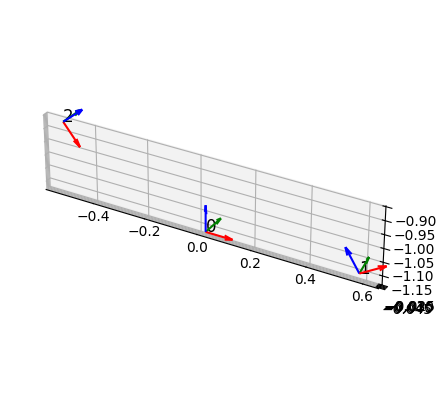

In [153]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    #pose_est[cam_id] = pose_est[cam_id].inv() @ pose_est[wrl_idx]
    plot_frame(ax, pose_est[cam_id]._pose , cam_id) # TODO: make a getter for the A matrix

# aspect ratio of the plot to be equal
ax.set_aspect('equal')

print(ax.get_box_aspect())
#make the plot interactive
plt.show()


In [154]:
%load_ext autoreload
%autoreload 2
    
from src.vican.vican.geometry import SE3, rotz
from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    
    cam.extrinsics = pose_est[cam_id] #@ SE3(R=rotz(np.pi), t=np.zeros((3,1)))
    # draw axis of frames of each camera

#dataset.cams{"4",SE3(R=np.eye)}

plot_cams_3D(dataset.cams.values())    

"file:///home/manuelf/ist/smart_retail/vicandocker/file.html"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'file:///home/manuelf/ist/smart_retail/vicandocker/file.html'

In [164]:
import open3d as o3d

# Load the PCD file
pc0 = o3d.io.read_point_cloud("dataset/pointcloud0.pcd")
pc1 = o3d.io.read_point_cloud("dataset/pointcloud1.pcd")
pc2 = o3d.io.read_point_cloud("dataset/pointcloud2.pcd")

triad = o3d.open3d.geometry.TriangleMesh.create_coordinate_frame()

# transform point clouds to world frame
pc0.transform(pose_est['0']._pose)
pc1.transform(pose_est['1']._pose)
pc2.transform(pose_est['2']._pose)

# Visualize the point cloud
o3d.visualization.draw_geometries([pc2,pc0, triad])




libGL error: MESA-LOADER: failed to retrieve device information
libGL error: MESA-LOADER: failed to open amdgpu: /usr/lib/dri/amdgpu_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri)
libGL error: failed to load driver: amdgpu
libGL error: failed to open /dev/dri/card0: No such file or directory
libGL error: failed to load driver: radeonsi


In [136]:
position_list = []
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    position_list.append(pose_est[cam_id].t())
    print(np.linalg.det(pose_est[cam_id].R()))


print(position_list)


print(np.linalg.norm(position_list[0]- position_list[1]))
print(np.linalg.norm(position_list[1]- position_list[2]))
print(np.linalg.norm(position_list[2]- position_list[0]))

    #print(cam_id)
    #print(pose)
    

0.9999999
1.0
1.0000001
[array([-0.02957792, -0.06192285, -0.95139071]), array([ 0.55339324, -0.06911866, -0.92612467]), array([-0.55066189, -0.07009569, -0.68381289])]
0.58356278648293
1.1303334422047497
0.5858269334566955


In [163]:
import json
json_data = {}
for cam_id, pose in pose_est.items():    
    #check if cam_id is a valid camera index
    if "_" in cam_id:
        continue
    json_data[int(cam_id)] = {'R': pose_est[cam_id].R().tolist(), 't': pose_est[cam_id].t().tolist()}
    
with open("pose_est.json", 'w') as f:
    json.dump(json_data, f, indent=4)

print("done")

done


In [93]:
# get an array of 4 points in image frame and return the middle point
def get_middle_point(points):
    points = np.array(points)
    return np.mean(points, axis=0)


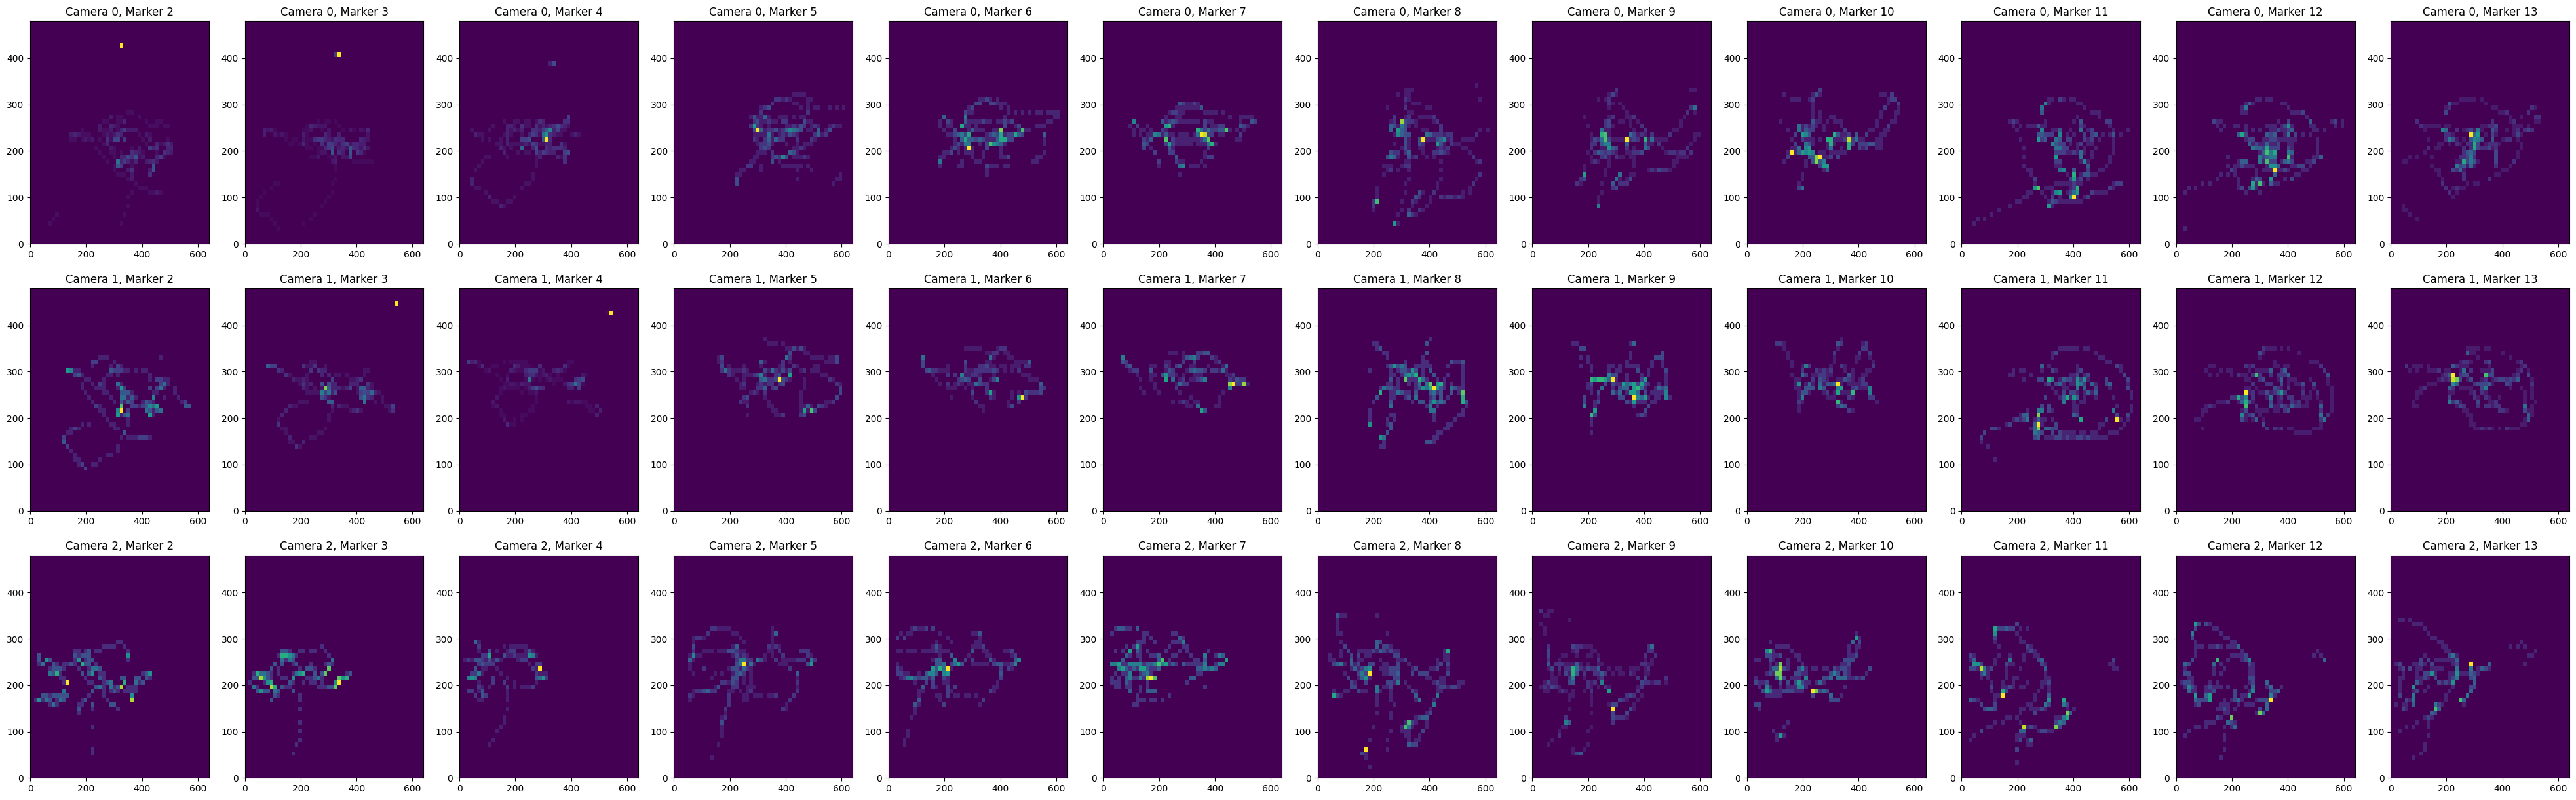

In [216]:
cam_marker_edges

#dict with all marker_id and camera_id
data = {}



for (camera, time_marker) in cam_marker_edges:
    #print(cam_marker_edges[(camera, time_marker)])
    time, marker = time_marker.split("_")
    
    # make every field in dictionary be a list and keep appending
    if (marker, camera) not in data:
        data[marker, camera] = []

    data[marker, camera].append( get_middle_point(cam_marker_edges[(camera, time_marker)]['corners']).tolist() )    

lst_mrk_ids = [int(int_id) for int_id in MARKER_IDS]
# create a subplot for every dictionary entry
fig, axs = plt.subplots(len(dataset.cams),len(MARKER_IDS),  figsize=(50, 15))

for i, (marker, camera) in enumerate(data):
    ax = axs[int(camera) , int(marker)- min(lst_mrk_ids)]
    new_data = np.array(data[marker, camera])
    ax.hist2d(new_data[:,0], new_data[:,1], bins=50,
             range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]))
    ax.set_title(f"Camera {camera}, Marker {marker}")

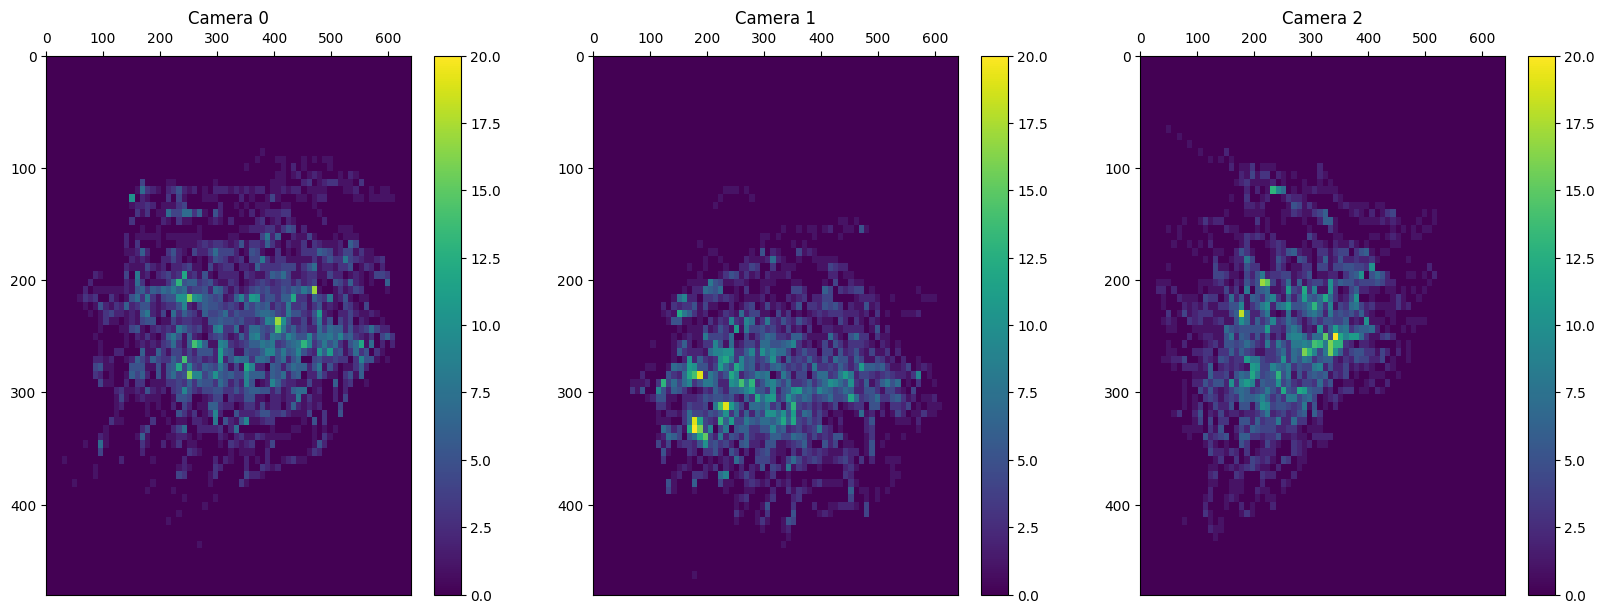

In [215]:
dict_merge_mrks = {}
for field in data.keys():
    
    if field[1] not in dict_merge_mrks:
        dict_merge_mrks[field[1]] = []
        
    dict_merge_mrks[field[1]].append(data[field])


dict_merge_mrks.keys()

fig, axs = plt.subplots(1, len(dataset.cams),  figsize=(20,7))

for i, camera in enumerate(dict_merge_mrks):
    ax = axs[int(camera)]
    new_data = np.concatenate(dict_merge_mrks[camera], axis=0)
    h = ax.hist2d(new_data[:,0], new_data[:,1], bins=70,
                 range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]),
                 vmin=0, vmax=20)  
    a = plt.colorbar(h[3], ax=ax)
    #a.set_ticks([-1, 0, 1])

        
    ax.set_title(f"Camera {camera}")
    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()



    

In [214]:
import cv2 as cv

from src.vican.vican.plot import draw_marker

print(dataset.im_data["filename"][3])

im = cv.imread(dataset.im_data["filename"][3])


aruco= "DICT_ARUCO_ORIGINAL"
corner_refine = "CORNER_REFINE_SUBPIX"

dictionary = cv.aruco.Dictionary_get(eval('cv.aruco.' + aruco))
parameters = cv.varuco.DetectorParameters_create()
if corner_refine is not None:
    parameters.cornerRefinementMethod = eval('cv.aruco.' + corner_refine)
parameters.cornerRefinementMinAccuracy = 0.05
parameters.adaptieThreshConstant = 10
parameters.cornerRefinementMaxIterations = 50
parameters.adaptiveThreshWinSizeStep = 5
parameters.adaptiveThreshWinSizeMax = 35

marker_corners, marker_ids, _ = cv.aruco.detectMarkers(im, dictionary)

marker_points = np.array([[-1, 1, 0],
                              [1, 1, 0],
                              [1, -1, 0],
                              [-1, -1, 0]], dtype=np.float32)
    
marker_points *= MARKER_SIZE * 0.5

print(marker_points)

im = cv.aruco.drawDetectedMarkers(im, marker_corners, marker_ids)

flag, rvec, t = cv.solvePnP(np.concatenate([marker_points[2], marker_points[3], marker_points[4] ]),
                            imagePoints=np.concatenate( [ marker_corners[2], marker_corners[3], marker_corners[4] ] ),
                            cameraMatrix=dataset.cams["0"].intrinsics,
                            distCoeffs=dataset.cams["0"].distortion )

print(marker_corners)
print(marker_ids)



./dataset/big_dataset/733/1.jpg
[[-0.0435  0.0435  0.    ]
 [ 0.0435  0.0435  0.    ]
 [ 0.0435 -0.0435  0.    ]
 [-0.0435 -0.0435  0.    ]]


IndexError: index 4 is out of bounds for axis 0 with size 4